# FLAN (Fine-tuned Language Net)

This notebook explores the key ideas from "Finetuned Language Models Are Zero-Shot Learners" (Wei et al., 2021), using the FLAN-T5 models that were later released as part of "The Flan Collection" (Longpre et al., 2023). While the original FLAN paper introduced the concept of instruction tuning for zero-shot learning, the models (LaMBDA-PT models) weren't publicly released. Instead, we'll use the publicly available FLAN-T5 models, which built upon and expanded these initial ideas. We use a community implementation of the FLAN dataset available on HuggingFace [here](https://huggingface.co/datasets/Muennighoff/flan).

The notebook is organized as follows:

- Import statements and auxilary functions
- Data exploration
  FLAN dataset consists of 62 tasks split into 12 clusters

**Experiments**
- Scaling Properties of FLAN
  - Evaluate 5 FLAN-T5 models each of different size on three clusters  
- Few-shot vs. Zero-shot performance
  - Compare few-shot and zero-shot FLAN performance

**Note on resources**:
- This Colab presents a minimal reproduction of the above. To reproduce the full results, increase `num_samples` and uncomment larger models in each section. All plotted results were produced using a random subset of 1000 test examples with seed=42. Cached results are loaded in each plot subsection.
- All models up-to XXL can be run on a single GPU, to produce the results in this notebook I used an RTX6000, however for XXL model, I used 4 RTX6000 GPUs.

**Papers Mentioned**:

- [Finetuned Language Models Are Zero-Shot Learners](https://arxiv.org/abs/2109.01652)
  Jason Wei∗, Maarten Bosma∗, Vincent Y. Zhao∗, Kelvin Guu∗, Adams Wei Yu, Brian Lester, Nan Du, Andrew M. Dai, and Quoc V. Le

- For FLAN-2 see [The Flan Collection: Designing Data and Methods for Effective Instruction Tuning](https://github.com/google-research/FLAN/tree/main/flan/v2) by
  Shayne Longpre∗, Le Hou, Tu Vu, Albert Webson, Hyung Won Chung, Yi Tay, Denny Zhou, Quoc V. Le, Barret Zoph, Jason Wei, Adam Roberts


In [1]:
! pip install transformers datasets evaluate accelerate

In [2]:
! pip install abs rouge_score nltk

## Preparation


In [3]:
import itertools
import math
import traceback
from pathlib import Path
from pprint import pprint
from typing import Dict, List, Tuple

import evaluate
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import torch
from datasets import Dataset, load_dataset
from transformers import (
    AutoModelForSeq2SeqLM,
    AutoTokenizer,
    DataCollatorForSeq2Seq,
    Seq2SeqTrainer,
    Seq2SeqTrainingArguments,
)


In [4]:
def get_max_memory_map():
    num_gpus = torch.cuda.device_count()
    # modify according to your GPU
    d = {i: "20GB" for i in range(num_gpus)}
    return d


def load_model_and_tokenizer(
    model_name,
) -> Tuple[AutoModelForSeq2SeqLM, AutoTokenizer, int]:
    """Load model and tokenizer"""
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    model = AutoModelForSeq2SeqLM.from_pretrained(
        model_name,
        device_map="balanced",  # Try balanced instead of auto
        torch_dtype=torch.float16,
        low_cpu_mem_usage=True,
        max_memory=get_max_memory_map(),  # Set explicit memory limits
        use_safetensors=True,  # This prefers PyTorch/SafeTensors format, useful for 11b model
    )
    model_params = sum([p.numel() for p in model.parameters()])

    return model, tokenizer, model_params


## Preprocessing & Metrics


In [5]:
def compute_metrics(tokenizer):
    def compute_metrics_(eval_pred):
        """Compute ROUGE, BLEU, and accuracy metrics"""
        rouge = evaluate.load("rouge")
        bleu = evaluate.load("bleu")
        accuracy = evaluate.load("exact_match")

        predictions, labels = eval_pred
        predictions = np.where(predictions != -100, predictions, tokenizer.pad_token_id)
        decoded_preds = tokenizer.batch_decode(predictions, skip_special_tokens=True)

        labels = np.where(labels != -100, labels, tokenizer.pad_token_id)
        decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)

        # Exact match accuracy
        exact_match_score = accuracy.compute(
            predictions=[p.strip().lower() for p in decoded_preds],
            references=[l.strip().lower() for l in decoded_labels],
        )

        # ROUGE scores
        rouge_scores = rouge.compute(
            predictions=decoded_preds,
            references=decoded_labels,
            use_stemmer=True,
        )

        # BLEU score
        bleu_score = bleu.compute(
            predictions=decoded_preds, references=[[l] for l in decoded_labels]
        )

        return {
            "accuracy": exact_match_score["exact_match"],
            "rouge1": rouge_scores["rouge1"],
            "rouge2": rouge_scores["rouge2"],
            "rougeL": rouge_scores["rougeL"],
            "bleu": bleu_score["bleu"],
        }

    return compute_metrics_

## Data

The original paper uses seqio to produce the instruction mixture, this notebook uses a pre-processed community implementation of the FLAN dataset available on HuggingFace [here](https://huggingface.co/datasets/Muennighoff/flan).


In [56]:
ds = load_dataset(
    "Muennighoff/flan",
    split="test",
    streaming=True,
).shuffle(seed=42)

train_ds = load_dataset(
    "Muennighoff/flan",
    split="train",
    streaming=True,
).shuffle(seed=42)

Resolving data files:   0%|          | 0/66 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/66 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/66 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/66 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/66 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/66 [00:00<?, ?it/s]

### Clusters

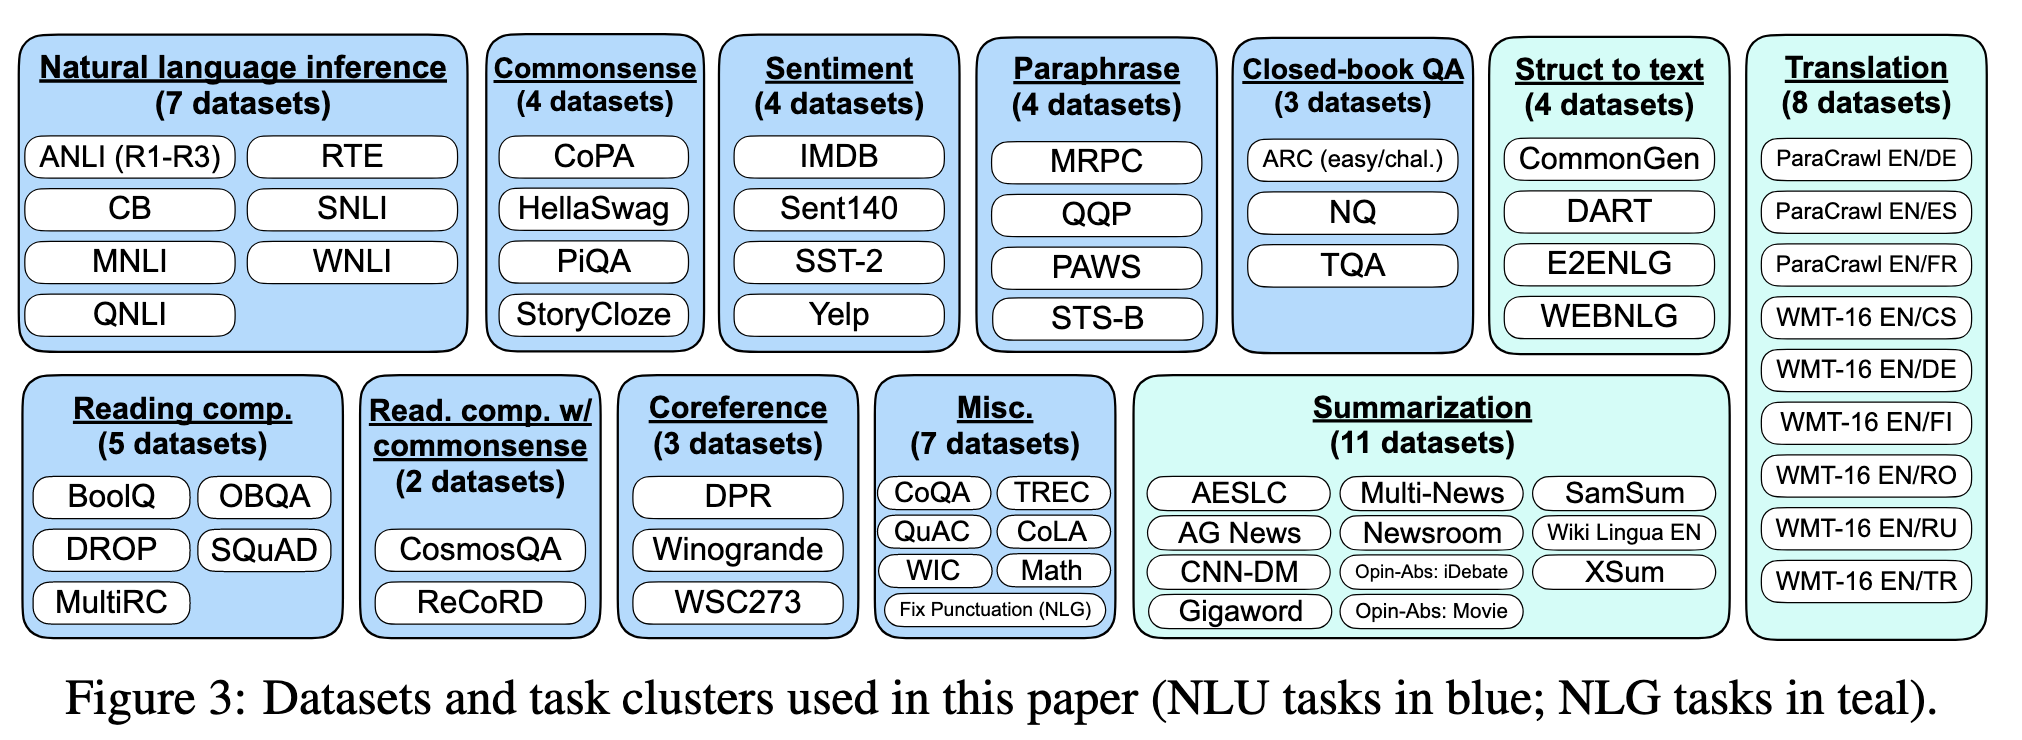

In [7]:
task_clusters = {
    "held-out": [
        ## nli
        "anli_r1_10templates",
        "anli_r2_10templates",
        "anli_r3_10templates",
        "cb_10templates",
        "mnli_matched_10templates",
        "mnli_mismatched_10templates",
        "qnli_10templates",
        "snli_10templates",
        "wnli_10templates",
        "rte_10templates",
        ## common-sense
        "copa_10templates",
        "hellaswag_10templates",
        "piqa_10templates",
        "story_cloze_10templates"
        ## closed-book qa
        "arc_challenge_10templates",
        "arc_easy_10templates",
        "natural_questions_10templates",
        "trivia_qa_10templates",
    ],
    "natural_language_inference": [
        "anli_r1_10templates",
        "anli_r2_10templates",
        "anli_r3_10templates",
        "cb_10templates",
        "mnli_matched_10templates",
        "mnli_mismatched_10templates",
        "qnli_10templates",
        "snli_10templates",
        "wnli_10templates",
        "rte_10templates",
    ],
    "reading_comprehension": [
        "bool_q_10templates",
        "drop_10templates",
        "multirc_10templates",
        "openbookqa_10templates",
        "squad_v1_10templates",
        "squad_v2_10templates",
    ],
    "commonsense_reasoning": [
        "copa_10templates",
        "hellaswag_10templates",
        "piqa_10templates",
        "story_cloze_10templates",
    ],
    "sentiment_analysis": [
        "imdb_reviews_10templates",
        "sentiment140_10templates",
        "sst2_10templates",
        "yelp_polarity_reviews_10templates",
    ],
    "closed_book_qa": [
        "arc_challenge_10templates",
        "arc_easy_10templates",
        "natural_questions_10templates",
        "trivia_qa_10templates",
    ],
    "paraphrase_detection": [
        "glue_mrpc_10templates",
        "glue_qqp_10templates",
        "paws_wiki_10templates",
    ],
    "coreference_resolution": [
        "definite_pronoun_resolution_10templates",
        "wsc_10templates",
    ],
    "reading_comprehension_with_commonsense": [
        "cosmos_qa_10templates",
        "record_10templates",
    ],
    "struct_to_text": [
        "common_gen_10templates",
        "dart_10templates",
        "e2e_nlg_10templates",
        "web_nlg_en_10templates",
    ],
    "translation": [
        "para_crawl_enes_10templates",
        "wmt14_enfr_10templates",
        "wmt16_translate_csen_10templates",
        "wmt16_translate_deen_10templates",
        "wmt16_translate_fien_10templates",
        "wmt16_translate_roen_10templates",
        "wmt16_translate_ruen_10templates",
        "wmt16_translate_tren_10templates",
    ],
    "summarization": [
        "aeslc_10templates",
        "cnn_dailymail_10templates",
        "gigaword_10templates",
        "multi_news_10templates",
        "samsum_10templates",
        "opinion_abstracts_idebate_10templates",
        "opinion_abstracts_rotten_tomatoes_10templates",
        "wiki_lingua_english_en_10templates",
    ],
    "miscellaneous": [
        "ag_news_subset_10templates",  # News classification
        "cola_10templates",  # Linguistic acceptability
        "coqa_10templates",  # Conversational QA
        "quac_10templates",  # Conversational QA
        "fix_punct_10templates",  # Text correction
        "math_dataset_10templates",  # Mathematics
        "stsb_10templates",  # Semantic similarity
        "trec_10templates",  # Question classification
        "true_case_10templates",  # Text normalization
        "wic_10templates",  # Word sense disambiguation
        "word_segment_10templates",  # Word segmentation
    ],
}

### Data Exploration

In [57]:
print("Exploring FLAN Dataset Format:\n")
print("=" * 80)

examples = ds.take(5)

for i, example in enumerate(examples):
    print(f"\nExample {i + 1}:")
    print("-" * 40)
    print("Input Instruction/Question:")
    print(f"{example['inputs']}")
    print("\nTarget/Expected Output:")
    print(f"{example['targets']}")
    print("\nTask Type/Template:")
    print(f"{example['task']}")
    print("=" * 80)


Exploring FLAN Dataset Format:


Example 1:
----------------------------------------
Input Instruction/Question:
What is the answer: What name was given to a series of thirty evening radio speeches given by US President Franklin D. Roosevelt in 1933 and 1944?

Target/Expected Output:
fireside chats

Task Type/Template:
trivia_qa_10templates

Example 2:
----------------------------------------
Input Instruction/Question:
What is the answer: The Great Sphinx of Giza in Egypt is a statue of a reclining mythical creature with a lion's body and the head of a what?

Target/Expected Output:
human

Task Type/Template:
trivia_qa_10templates

Example 3:
----------------------------------------
Input Instruction/Question:
Question: "What is the more common name of the ""simple plurality"" system of voting?"
Answer:

Target/Expected Output:
first past post

Task Type/Template:
trivia_qa_10templates

Example 4:
----------------------------------------
Input Instruction/Question:
Question: Which Fre

## Scaling Properties

In this part, we will reproduce Figure 7 (Section 4.2) from the FLAN paper, which evaluates the effect of instruction tuning on models with 422M, 2B, 8B, 68B, and 137B parameters.  
Since we don't have access to the original models, we use two model families:
**FLAN-T5 (Instruction-tuned models):**

- google/flan-t5-small (80M parameters)
- google/flan-t5-base (250M parameters)
- google/flan-t5-large (780M parameters)
- google/flan-t5-xl (3B parameters)
- google/flan-t5-xxl (11B parameters)

**T5 (Base models without instruction tuning):**

- google-t5/t5-small (80M parameters)
- google-t5/t5-base (250M parameters)
- google-t5/t5-large (780M parameters)
- google-t5/t5-3b (3B parameters)
- google-t5/t5-11b (11B parameters)

For each model size, we evaluate performance on held-out task clusters (Commonsense, NLI, and Closed-book QA) to measure how instruction tuning affects performance at different scales. By comparing FLAN-T5 against the original T5 models, we can observe whether the benefits of instruction tuning increase with model size, as demonstrated in the original paper.


In [9]:
def get_training_args(model_name):
    """Get appropriate args based on model size"""
    generation_max_length = 128
    eval_accumulation_steps = 4
    if "xxl" in model_name:
        bs = 1  # Most conservative for 11B model
        generation_max_length = 64
        eval_accumulation_steps = 1
    elif "xl" in model_name or "3b" in model_name:
        bs = 2  # 3B params
    elif "large" in model_name:
        bs = 4  # 780M params
    elif "base" in model_name:
        bs = 8  # 250M params
    elif "small" in model_name:
        bs = 16  # 80M params
    else:
        bs = 4
    return {
        "per_device_eval_batch_size": bs,
        "generation_max_length": generation_max_length,
        "eval_accumulation_steps": eval_accumulation_steps,
    }


def get_task_samples(dataset, cluster_name, num_samples=10):
    """Get n examples from a specific cluster"""
    filtered_samples = []
    cnt = 0
    for sample in dataset:
        if (
            cluster_name is None
            or sample["task"].lower() in task_clusters[cluster_name]
        ):
            filtered_samples.append(sample)
            cnt += 1
            if cnt == num_samples:
                break
    return filtered_samples


def get_examples_by_task(dataset, task_name, split="train", n_examples=5):
    """Get n examples from a specific task"""
    examples = []
    for sample in dataset:
        if sample["task"] == task_name:
            examples.append({"inputs": sample["inputs"], "targets": sample["targets"]})
            if len(examples) == n_examples:
                break
    return examples


#uncomment to run larger models
models = [
    # 'google/flan-t5-xxl',
    # "google-t5/t5-11b",
    "google/flan-t5-small",
    "google/flan-t5-base",
    # "google/flan-t5-large",
    # "google/flan-t5-xl",
    # "google-t5/t5-small",
    # "google-t5/t5-base",
    # "google-t5/t5-3b",
    # "google-t5/t5-large",
]

In [10]:
def evaluate_models(
    model_names: List[str], task_name: str = None, num_samples: int = 1000
):
    # Load test dataset
    ds = load_dataset("Muennighoff/flan", split="test", streaming=True).shuffle(seed=42)
    test_samples = get_task_samples(ds, task_name, num_samples)

    # Create initial dataset
    eval_dataset = Dataset.from_dict(
        {
            "inputs": [sample["inputs"] for sample in test_samples],
            "targets": [sample["targets"] for sample in test_samples],
        }
    )

    results = []

    for model_name in model_names:
        try:
            print(f"\nEvaluating {model_name}")
            model, tokenizer, model_size = load_model_and_tokenizer(model_name)

            # First tokenize the dataset
            def tokenize_function(examples):
                model_inputs = tokenizer(
                    examples["inputs"],
                    padding=True,
                    truncation=True,
                    max_length=512,
                    return_tensors=None,
                )

                # Tokenize targets
                with tokenizer.as_target_tokenizer():
                    labels = tokenizer(
                        examples["targets"],
                        padding=True,
                        truncation=True,
                        max_length=128,
                        return_tensors="pt",
                    )

                model_inputs["labels"] = labels["input_ids"]
                return model_inputs

            # Process dataset
            processed_dataset = eval_dataset.map(
                tokenize_function,
                batched=True,
                remove_columns=eval_dataset.column_names,
            )

            kwargs = get_training_args(model_name)
            training_args = Seq2SeqTrainingArguments(
                output_dir=f"./results_{model_name}",
                predict_with_generate=True,
                generation_num_beams=2,
                fp16=True,
                report_to="none",
                **kwargs,
            )
            data_collator = DataCollatorForSeq2Seq(
                tokenizer=tokenizer,
                model=model,
                padding=True,
                return_tensors="pt",
                label_pad_token_id=-100,
            )
            trainer = Seq2SeqTrainer(
                model=model,
                args=training_args,
                compute_metrics=compute_metrics(tokenizer),
                eval_dataset=eval_dataset,
                data_collator=data_collator,
            )

            # Evaluate
            print("Running trainer.evaluate")
            eval_results = trainer.evaluate(eval_dataset=processed_dataset)

            result = {
                "model": model_name,
                "model_size": model_size,
                "rouge1": eval_results["eval_rouge1"],
                "rouge2": eval_results["eval_rouge2"],
                "rougeL": eval_results["eval_rougeL"],
                "bleu": eval_results["eval_bleu"],
                "accuracy": eval_results["eval_accuracy"],
            }
            results.append(result)
            print(f"\nEvaluating {model_name} complete.")
            print(result)

            del model
            del trainer
        except:
            print(f"Problem with {model_name}, please run the evaluation again.")
            print(traceback.format_exc())
        torch.cuda.empty_cache()

    return pd.DataFrame(results)


In [11]:
eval_tasks = ["natural_language_inference", "commonsense_reasoning", "closed_book_qa"]
num_samples = 10
for task_name in eval_tasks:
    print(f"Running eval on {task_name}")
    # FLAN-T5 and T5 Run evaluation & save results
    results_df = evaluate_models(models, task_name, num_samples)
    results_df.to_csv(
        f"nb_flan_t5_{task_name}_scaling_results_{num_samples}.csv", index=False
    )


Running eval on natural_language_inference


Resolving data files:   0%|          | 0/66 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/66 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/66 [00:00<?, ?it/s]


Evaluating google/flan-t5-small


Map:   0%|          | 0/10 [00:00<?, ? examples/s]

/usr/local/lib/python3.11/dist-packages/transformers/tokenization_utils_base.py:3961: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(


Running trainer.evaluate


Passing a tuple of `past_key_values` is deprecated and will be removed in Transformers v4.48.0. You should pass an instance of `EncoderDecoderCache` instead, e.g. `past_key_values=EncoderDecoderCache.from_legacy_cache(past_key_values)`.



Evaluating google/flan-t5-small complete.
{'model': 'google/flan-t5-small', 'model_size': 76961152, 'rouge1': 0.10683760683760683, 'rouge2': 0.0, 'rougeL': 0.10683760683760683, 'bleu': 0.0, 'accuracy': 0.1}

Evaluating google/flan-t5-base


Map:   0%|          | 0/10 [00:00<?, ? examples/s]

/usr/local/lib/python3.11/dist-packages/transformers/tokenization_utils_base.py:3961: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(


Running trainer.evaluate



Evaluating google/flan-t5-base complete.
{'model': 'google/flan-t5-base', 'model_size': 247577856, 'rouge1': 0.6169491525423728, 'rouge2': 0.0, 'rougeL': 0.611864406779661, 'bleu': 0.0, 'accuracy': 0.6}
Running eval on commonsense_reasoning


Resolving data files:   0%|          | 0/66 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/66 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/66 [00:00<?, ?it/s]


Evaluating google/flan-t5-small


Map:   0%|          | 0/10 [00:00<?, ? examples/s]

/usr/local/lib/python3.11/dist-packages/transformers/tokenization_utils_base.py:3961: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(


Running trainer.evaluate



Evaluating google/flan-t5-small complete.
{'model': 'google/flan-t5-small', 'model_size': 76961152, 'rouge1': 0.678533779103039, 'rouge2': 0.6285714285714286, 'rougeL': 0.6811903255926026, 'bleu': 0.1776180788454798, 'accuracy': 0.6}

Evaluating google/flan-t5-base


Map:   0%|          | 0/10 [00:00<?, ? examples/s]

/usr/local/lib/python3.11/dist-packages/transformers/tokenization_utils_base.py:3961: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(


Running trainer.evaluate



Evaluating google/flan-t5-base complete.
{'model': 'google/flan-t5-base', 'model_size': 247577856, 'rouge1': 0.5459637188208617, 'rouge2': 0.42857142857142855, 'rougeL': 0.5410090702947845, 'bleu': 0.14674804254493076, 'accuracy': 0.4}
Running eval on closed_book_qa


Resolving data files:   0%|          | 0/66 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/66 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/66 [00:00<?, ?it/s]


Evaluating google/flan-t5-small


Map:   0%|          | 0/10 [00:00<?, ? examples/s]

/usr/local/lib/python3.11/dist-packages/transformers/tokenization_utils_base.py:3961: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(


Running trainer.evaluate



Evaluating google/flan-t5-small complete.
{'model': 'google/flan-t5-small', 'model_size': 76961152, 'rouge1': 0.30964674128760816, 'rouge2': 0.13235294117647062, 'rougeL': 0.2860268317853457, 'bleu': 0.064630267983707, 'accuracy': 0.0}

Evaluating google/flan-t5-base


Map:   0%|          | 0/10 [00:00<?, ? examples/s]

/usr/local/lib/python3.11/dist-packages/transformers/tokenization_utils_base.py:3961: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(


Running trainer.evaluate



Evaluating google/flan-t5-base complete.
{'model': 'google/flan-t5-base', 'model_size': 247577856, 'rouge1': 0.45532904659839646, 'rouge2': 0.2323529411764706, 'rougeL': 0.43766214177978885, 'bleu': 0.12054507549945886, 'accuracy': 0.2}


### Plot Scaling Results

1. Fetch results run on the cluster
2. Plot metrics

Note that we refrain from plotting the base model (T5) since we were unable to get meaningful results from the no instruction tuning model.


In [12]:
! mkdir -p results
! wget -O results/flan_t5_commonsense_reasoning_scaling_results_1000.csv --no-check-certificate "https://drive.google.com/uc?export=download&id=1HCeZP_KkRcz4RgggUoacUF07Oe9Hl6HN"
! wget -O results/flan_t5_natural_language_inference_scaling_results_1000.csv --no-check-certificate "https://drive.google.com/uc?export=download&id=1PywOFJRtK8pucPmNG4fDflrSknFlQjSH"
! wget -O results/flan_t5_closed_book_qa_scaling_results_1000.csv --no-check-certificate "https://drive.google.com/uc?export=download&id=1h9ajyCfHnJSP9x0SuxthGPOtSPhnbPdw"

--2025-02-14 03:41:20--  https://drive.google.com/uc?export=download&id=1HCeZP_KkRcz4RgggUoacUF07Oe9Hl6HN
Resolving drive.google.com (drive.google.com)... 142.251.2.138, 142.251.2.139, 142.251.2.102, ...
Connecting to drive.google.com (drive.google.com)|142.251.2.138|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://drive.usercontent.google.com/download?id=1HCeZP_KkRcz4RgggUoacUF07Oe9Hl6HN&export=download [following]
--2025-02-14 03:41:20--  https://drive.usercontent.google.com/download?id=1HCeZP_KkRcz4RgggUoacUF07Oe9Hl6HN&export=download
Resolving drive.usercontent.google.com (drive.usercontent.google.com)... 142.251.2.132, 2607:f8b0:4023:c0d::84
Connecting to drive.usercontent.google.com (drive.usercontent.google.com)|142.251.2.132|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1163 (1.1K) [application/octet-stream]
Saving to: ‘results/flan_t5_commonsense_reasoning_scaling_results_1000.csv’

results/flan_t5_com 100%[

In [30]:
df = None
for task in ["closed_book_qa", "natural_language_inference", "commonsense_reasoning"]:
    p = Path("results", f"flan_t5_{task}_scaling_results_1000.csv")
    data = pd.read_csv(p)
    data["task"] = task
    if df is None:
        df = data
    else:
        df = pd.concat((df, data))


def format_size(x: int) -> str:
    """pretty format model size"""
    if x > 1e9:
        return f"{math.ceil(x / 1e9)}B"
    return f"{math.ceil(x / 1e6)}M"


# Determine if model is Flan or not
df["is_flan"] = df["model"].str.contains("flan-t5")
df["model_size_pretty"] = df["model_size"].apply(format_size)
df = df[df["is_flan"]]

df.head()

,model,model_size,rouge1,rouge2,rougeL,bleu,accuracy,task,is_flan,model_size_pretty
0,google/flan-t5-small,76961152,0.079276,0.031566,0.076613,0.049064,0.033,closed_book_qa,True,77M
1,google/flan-t5-xxl,11135332352,0.371837,0.156156,0.369359,0.239699,0.295,closed_book_qa,True,12B
3,google/flan-t5-base,247577856,0.132535,0.044738,0.129709,0.115133,0.067,closed_book_qa,True,248M
4,google/flan-t5-large,783150080,0.218872,0.077095,0.216163,0.164947,0.155,closed_book_qa,True,784M
5,google/flan-t5-xl,2849757184,0.316247,0.118156,0.314141,0.249075,0.249,closed_book_qa,True,3B


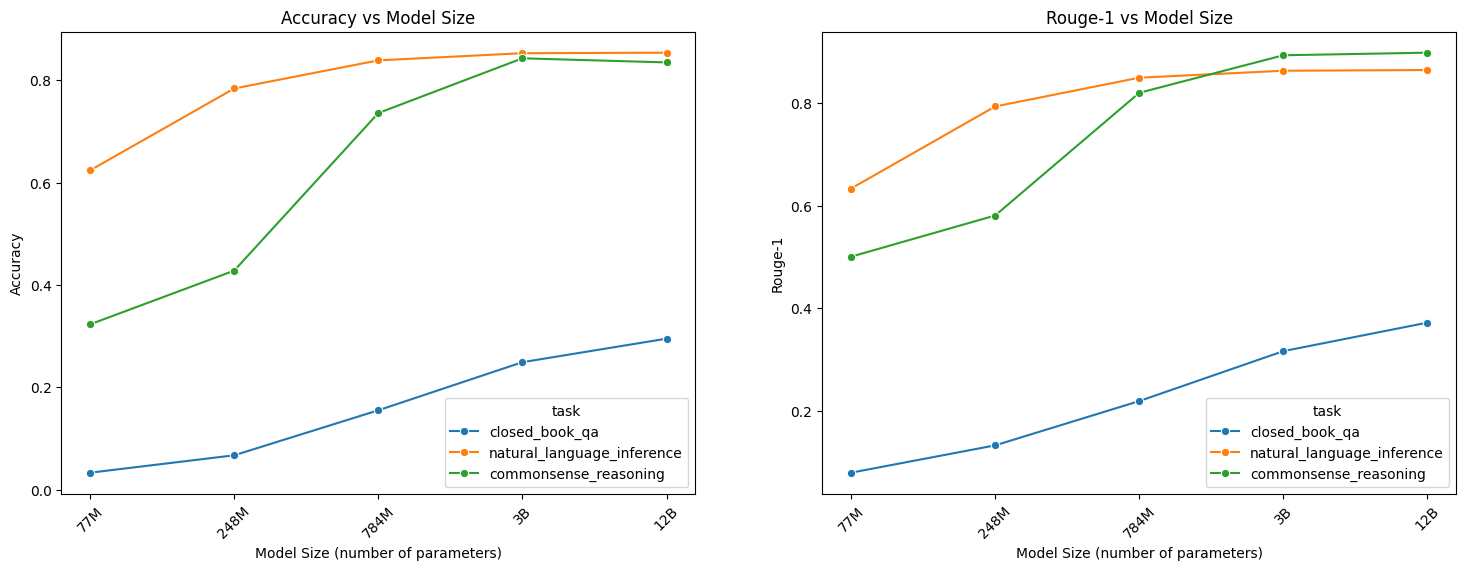

In [39]:
# Create subplots for different metrics
fig, axs = plt.subplots(1, 2, figsize=(18, 6))

## Accuracy plot
ax = axs[0]
ax.set_title("Accuracy vs Model Size")
sns.lineplot(
    data=df.sort_values("model_size"),
    x="model_size_pretty",
    y="accuracy",
    hue="task",
    marker="o",
    ax=ax,
)
ax.set_xlabel("Model Size (number of parameters)")
ax.set_ylabel("Accuracy")
ax.tick_params(axis="x", rotation=45)

## Rouge plot
ax = axs[1]
ax.set_title("Rouge-1 vs Model Size")
sns.lineplot(
    data=df.sort_values("model_size"),
    x="model_size_pretty",
    y="rouge1",
    hue="task",
    marker="o",
    ax=ax,
)
ax.set_xlabel("Model Size (number of parameters)")
ax.set_ylabel("Rouge-1")
ax.tick_params(axis="x", rotation=45)


## Few-shot vs. Zero-shot Performance

In this part, we will reproduce the comparison between few-shot and zero-shot FLAN performance. We use T5-FLAN-Large, which has ~750M parameters and achieves competitive performance above.

We follow the paper's formulation for few-shot prompting, where they concatenate `instruct(x_k) ⊕ y_k ⊕ ... ⊕ instruct(prompt) `.

**Limitations**:
- This format for few-shot prompts may not be the optimal format, we also don't employ a special token but only separate the few shot examplars by `\n`.
- We don't have a rigorous few-shot sampling approach, for each task we pick few-shot examples in the beginning and use the same examplars for all test samples in that dataset.
  While this performs well for natural language inference, we see that it doesn't help in settings where more carefully curated samples could help more, like closed book qa.
- We don't observe consistent gains with few-shot prompting. It is possible that the authors use a more complex few-shot strategy than what is employed here.

### Few-shot utils

In [16]:
def create_few_shot_prompt(examples, test_input):
    """Create a few-shot prompt following the paper's format:
    instruct(x_k) ⊕ y_k ⊕ instruct(x)
    where ⊕ represents string concatenation with a delimiter token
    """
    # Using "\n" as the delimiter token
    prompt = ""
    for ex in examples:
        # Add each example as instruction(x_k) \n y_k
        prompt += f"{ex['inputs']}\n {ex['targets']} \n\n "

    # Add the final test input instruction(x)
    prompt += test_input

    return prompt

In [62]:
print("Exploring FLAN Dataset Few-Shot Format:\n")
print("=" * 80)

examples = ds.take(1)

for i, example in enumerate(examples):
    print(f"\nExample {i + 1}:")
    print("-" * 40)
    print("Few-shot Input Instruction/Question")
    task = example["task"]
    few_shot_examples = get_examples_by_task(train_ds, task)
    print(create_few_shot_prompt(few_shot_examples, example["inputs"]))
    print("\nTarget/Expected Output:")
    print(f"{example['targets']}")
    print("\nTask Type/Template:")
    print(f"{example['task']}")
    print("=" * 80)



Exploring FLAN Dataset Few-Shot Format:


Example 1:
----------------------------------------
Few-shot Input Instruction/Question
Answer the following question. In which sea is the island of Barbados?
 caribbean 

 Where is David Cameron’s Oxfordshire constituency?
What is the answer?
 witney 

 Answer the following question. FT (London) Dow Jones (USA) what is Japans Share Index called?
 nikkei 

 Who is the founder of the Wikileaks website?
 julian assange 

 Answer this question.

In which film series does Keanu Reeves play a computer hacker with the alias Neo?
 matrix 

 What is the answer: What name was given to a series of thirty evening radio speeches given by US President Franklin D. Roosevelt in 1933 and 1944?

Target/Expected Output:
fireside chats

Task Type/Template:
trivia_qa_10templates


### Few-shot evaluation

In [17]:
def evaluate_model_performance(
    model, tokenizer, test_dataset, few_shot_examples: Dict = None, batch_size=8
):
    """Evaluate model using Trainer"""

    def tokenize_function(examples):
        inputs = examples["inputs"]
        if few_shot_examples:
            inputs = [
                create_few_shot_prompt(few_shot_examples[task], x)
                for task, x in zip(examples["task"], examples["inputs"])
            ]
        model_inputs = tokenizer(
            inputs,
            padding=True,
            truncation=True,
            max_length=512,
            return_tensors=None,
        )

        # Tokenize targets
        with tokenizer.as_target_tokenizer():
            labels = tokenizer(
                examples["targets"],
                padding=True,
                truncation=True,
                max_length=128,
                return_tensors="pt",
            )

        model_inputs["labels"] = labels["input_ids"]
        return model_inputs

    # Prepare the dataset
    processed_dataset = test_dataset.map(
        tokenize_function,
        batched=True,
        remove_columns=test_dataset.column_names,
    )

    # Create training arguments
    training_args = Seq2SeqTrainingArguments(
        output_dir="./results",
        per_device_eval_batch_size=batch_size,
        predict_with_generate=True,
        generation_max_length=128,
        generation_num_beams=4,
        fp16=True,
        report_to="none",
    )

    data_collator = DataCollatorForSeq2Seq(
        tokenizer=tokenizer,
        model=model,
        padding=True,
        return_tensors="pt",
        label_pad_token_id=-100,
    )

    trainer = Seq2SeqTrainer(
        model=model,
        args=training_args,
        data_collator=data_collator,
        compute_metrics=compute_metrics(tokenizer),
    )

    # Run evaluation
    metrics = trainer.evaluate(eval_dataset=processed_dataset)

    return metrics


In [18]:
def run_few_shot_eval(clusters, num_samples: int = 1000,
                      model_name: str = "google/flan-t5-large"):
    print("Loading model and tokenizer...")
    model, tokenizer, _ = load_model_and_tokenizer(model_name=model_name)
    results_df = None
    results = []
    for cluster_name in clusters:
        print()
        print()
        print(cluster_name)

        # Load both training and test datasets, we will use training dataset
        # to generate few-shot examplars
        print("Loading datasets...")
        test_ds = load_dataset("Muennighoff/flan", split="test", streaming=True)
        test_ds = test_ds.shuffle(seed=42)
        train_ds = load_dataset("Muennighoff/flan", split="train", streaming=True)
        train_ds = train_ds.shuffle(seed=42)
        train_ds = get_task_samples(train_ds, cluster_name, 2000)
        # Evaluate on test examples
        print("Starting evaluation...")
        test_examples = get_task_samples(test_ds, cluster_name, num_samples)
        test_dataset = Dataset.from_dict(
            {
                "inputs": [ex["inputs"] for ex in test_examples],
                "targets": [ex["targets"] for ex in test_examples],
                "task": [ex["task"] for ex in test_examples],
            }
        )

        # Zero-shot evaluation
        print("\nRunning zero-shot evaluation...")
        zero_shot_metrics = evaluate_model_performance(model, tokenizer, test_dataset)
        result = {
            "setting": "zero-shot",
            "dataset": cluster_name,
            "rouge1": zero_shot_metrics["eval_rouge1"],
            "rouge2": zero_shot_metrics["eval_rouge2"],
            "rougeL": zero_shot_metrics["eval_rougeL"],
            "bleu": zero_shot_metrics["eval_bleu"],
            "accuracy": zero_shot_metrics["eval_accuracy"],
        }
        results.append(result)

        tasks = task_clusters[cluster_name]
        print("\nRunning few-shot evaluation...")
        # Get few-shot examples for each task
        task_examples = {}
        for task in tasks:
            task_examples[task] = get_examples_by_task(train_ds, task)

        # Create few-shot dataset with task-specific examples
        few_shot_metrics = evaluate_model_performance(
            model,
            tokenizer,
            test_dataset,
            few_shot_examples=task_examples,
        )
        result = {
            "setting": "few-shot",
            "dataset": cluster_name,
            "rouge1": few_shot_metrics["eval_rouge1"],
            "rouge2": few_shot_metrics["eval_rouge2"],
            "rougeL": few_shot_metrics["eval_rougeL"],
            "bleu": few_shot_metrics["eval_bleu"],
            "accuracy": few_shot_metrics["eval_accuracy"],
        }
        results.append(result)

    return pd.DataFrame(results)


In [19]:
clusters = [
    "natural_language_inference",
    "closed_book_qa",
    "commonsense_reasoning",
    "struct_to_text",
    "coreference_resolution",
    "reading_comprehension",
]
num_samples = 10
model_name = "google/flan-t5-large"
few_shot_results = run_few_shot_eval(clusters, num_samples, model_name)
few_shot_results.to_csv(f"nb_few_shot_{num_samples}.csv", index=False)

Loading model and tokenizer...


tokenizer_config.json:   0%|          | 0.00/2.54k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.42M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/2.20k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/662 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/3.13G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]



natural_language_inference
Loading datasets...


Resolving data files:   0%|          | 0/66 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/66 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/66 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/66 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/66 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/66 [00:00<?, ?it/s]

Starting evaluation...

Running zero-shot evaluation...


Map:   0%|          | 0/10 [00:00<?, ? examples/s]

/usr/local/lib/python3.11/dist-packages/transformers/tokenization_utils_base.py:3961: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(



Running few-shot evaluation...


Map:   0%|          | 0/10 [00:00<?, ? examples/s]

/usr/local/lib/python3.11/dist-packages/transformers/tokenization_utils_base.py:3961: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(




closed_book_qa
Loading datasets...


Resolving data files:   0%|          | 0/66 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/66 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/66 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/66 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/66 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/66 [00:00<?, ?it/s]

Starting evaluation...

Running zero-shot evaluation...


Map:   0%|          | 0/10 [00:00<?, ? examples/s]

/usr/local/lib/python3.11/dist-packages/transformers/tokenization_utils_base.py:3961: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(



Running few-shot evaluation...


Map:   0%|          | 0/10 [00:00<?, ? examples/s]

/usr/local/lib/python3.11/dist-packages/transformers/tokenization_utils_base.py:3961: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(




commonsense_reasoning
Loading datasets...


Resolving data files:   0%|          | 0/66 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/66 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/66 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/66 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/66 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/66 [00:00<?, ?it/s]

Starting evaluation...

Running zero-shot evaluation...


Map:   0%|          | 0/10 [00:00<?, ? examples/s]

/usr/local/lib/python3.11/dist-packages/transformers/tokenization_utils_base.py:3961: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(



Running few-shot evaluation...


Map:   0%|          | 0/10 [00:00<?, ? examples/s]

/usr/local/lib/python3.11/dist-packages/transformers/tokenization_utils_base.py:3961: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(




struct_to_text
Loading datasets...


Resolving data files:   0%|          | 0/66 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/66 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/66 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/66 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/66 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/66 [00:00<?, ?it/s]

Starting evaluation...

Running zero-shot evaluation...


Map:   0%|          | 0/10 [00:00<?, ? examples/s]

/usr/local/lib/python3.11/dist-packages/transformers/tokenization_utils_base.py:3961: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(



Running few-shot evaluation...


Map:   0%|          | 0/10 [00:00<?, ? examples/s]

/usr/local/lib/python3.11/dist-packages/transformers/tokenization_utils_base.py:3961: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(




coreference_resolution
Loading datasets...


Resolving data files:   0%|          | 0/66 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/66 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/66 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/66 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/66 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/66 [00:00<?, ?it/s]

Starting evaluation...

Running zero-shot evaluation...


Map:   0%|          | 0/10 [00:00<?, ? examples/s]

/usr/local/lib/python3.11/dist-packages/transformers/tokenization_utils_base.py:3961: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(



Running few-shot evaluation...


Map:   0%|          | 0/10 [00:00<?, ? examples/s]

/usr/local/lib/python3.11/dist-packages/transformers/tokenization_utils_base.py:3961: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(




reading_comprehension
Loading datasets...


Resolving data files:   0%|          | 0/66 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/66 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/66 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/66 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/66 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/66 [00:00<?, ?it/s]

Starting evaluation...

Running zero-shot evaluation...


Map:   0%|          | 0/10 [00:00<?, ? examples/s]

/usr/local/lib/python3.11/dist-packages/transformers/tokenization_utils_base.py:3961: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(



Running few-shot evaluation...


Map:   0%|          | 0/10 [00:00<?, ? examples/s]

/usr/local/lib/python3.11/dist-packages/transformers/tokenization_utils_base.py:3961: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(


### Plot Few-Shot vs. Zero-Shot


In [20]:
! mkdir -p results
! wget -O results/few-shot.csv --no-check-certificate "https://drive.google.com/uc?export=download&id=1XDHNo78lTGTNf4GTQIJTEJJMx1nIAdk0"


--2025-02-14 03:55:38--  https://drive.google.com/uc?export=download&id=1XDHNo78lTGTNf4GTQIJTEJJMx1nIAdk0
Resolving drive.google.com (drive.google.com)... 142.251.2.100, 142.251.2.139, 142.251.2.113, ...
Connecting to drive.google.com (drive.google.com)|142.251.2.100|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://drive.usercontent.google.com/download?id=1XDHNo78lTGTNf4GTQIJTEJJMx1nIAdk0&export=download [following]
--2025-02-14 03:55:38--  https://drive.usercontent.google.com/download?id=1XDHNo78lTGTNf4GTQIJTEJJMx1nIAdk0&export=download
Resolving drive.usercontent.google.com (drive.usercontent.google.com)... 142.251.2.132, 2607:f8b0:4023:c0d::84
Connecting to drive.usercontent.google.com (drive.usercontent.google.com)|142.251.2.132|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3280 (3.2K) [application/octet-stream]
Saving to: ‘results/few-shot.csv’

results/few-shot.cs 100%[===================>]   3.20K  --.-KB/s   

In [41]:
df = pd.read_csv("results/few-shot.csv", header=1).dropna(axis=1)
df = df.pivot(
    index=["dataset", "setting"], columns="metric", values="value"
).reset_index()
df.head()

metric,dataset,setting,accuracy,bleu,loss,rouge1,rouge2,rougeL
0,closed_book_qa,few-shot,0.128,0.0000,27.3635,0.1609,0.0348,0.1616
1,closed_book_qa,zero-shot,0.124,0.0000,27.6320,0.1550,0.0332,0.1559
2,commonsense_reasoning,few-shot,0.000,0.0000,30.7493,0.1403,0.0047,0.1251
3,commonsense_reasoning,zero-shot,0.780,0.8455,29.4124,0.8410,0.8025,0.8310
4,coreference_resolution,few-shot,0.800,0.8361,36.0625,0.8235,0.4485,0.8234


Text(0.5, 1.0, 'Rouge-1')

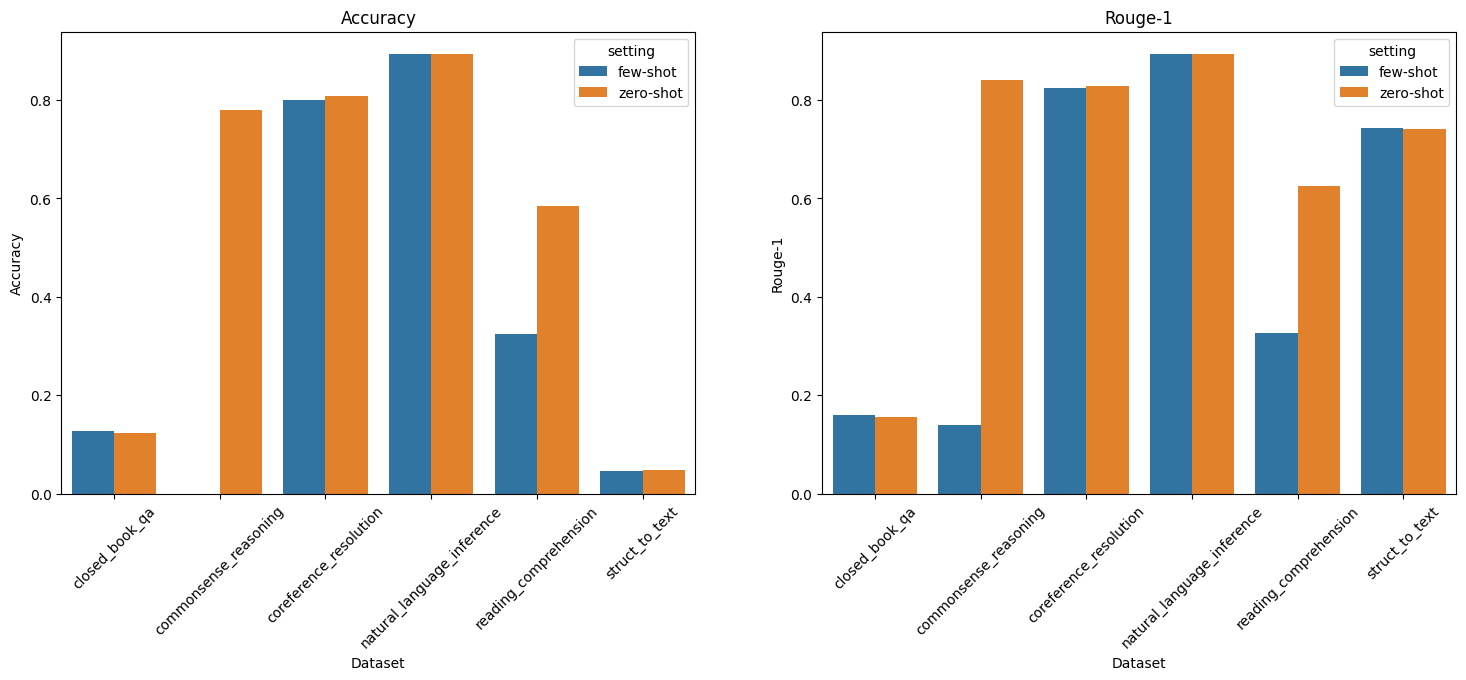

In [42]:
fig, axs = plt.subplots(1, 2, figsize=(18, 6))

ax = axs[0]
sns.barplot(data=df, x="dataset", y="accuracy", hue="setting", ax=ax)
ax.set_xlabel("Dataset")
ax.set_ylabel("Accuracy")
ax.tick_params(axis="x", rotation=45)
ax.set_title("Accuracy")

ax = axs[1]
sns.barplot(data=df, x="dataset", y="rouge1", hue="setting", ax=ax)
ax.set_xlabel("Dataset")
ax.tick_params(axis="x", rotation=45)
ax.set_ylabel("Rouge-1")
ax.set_title("Rouge-1")
